### Please see the accompanying paper "Quantifying glial-glial tiling using automated image analysis" for a full description of the pipeline and its validation.

### Our pipeline relies heaviliy on scikit-image, please look through their [documentation](https://scikit-image.org/) for full details about their library. 



In [1]:
import numpy as np
import skimage.io
from skimage.util import img_as_float
from skimage.filters import (unsharp_mask, threshold_otsu, 
                             threshold_triangle, threshold_li, threshold_yen,
                             try_all_threshold)
from skimage.morphology import (remove_small_objects, binary_dilation, binary_erosion,
                                remove_small_holes)
from skimage.measure import perimeter, label, regionprops
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random 
import csv
import pandas as pd


# Download Test Data

You can download test data from [Cell Image Library](http://cellimagelibrary.org/groups/54646). We have provided 45 
sample images (15 non-RNAi control, 15 driver 1 knockdown, and 15 driver 2 knockdown). Please download the test images and place them in a directory named "TestImages" located in the same directory as this Jupyter notebook. 

Note: Though we are providing 45 images to conduct a thorough test of the pipeline, for those interested in a quick test, we recommend only running 3-5 images to reduce running time. 

# Step 1: Denoising
Denoising reduces the noise in images allowing for more accurate binary images to be produced in the next step. We found the unsharp mask algorithm to be the most useful for denoising our data. The code below uses scikit-image's implementation of the algorithm to denoise a random test image for demonstration purposes. 

6L WT 5-9 Ctx488 AstroCy3 ElavCy5 20x 6.63X _X_10.tif


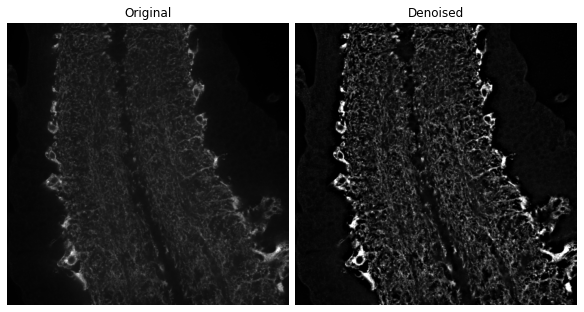

In [2]:
####DENOISE RANDOM TEST IMAGE#####

#make list of test image file names
dirPath = "TestImages"

testImgs = []
for root, dir, file in os.walk(dirPath):
    for f in file:
        if '.tif' in f:
            testImgs.append(f)

#choose random image file
imgName = random.choice(testImgs)
ipath=os.path.join(dirPath, imgName)
#select random channel
channel = [0, 1, 2]
c = random.choice(channel)
#load image with skimage
fullimg=skimage.io.imread(ipath, plugin="tifffile")
#select single channel 
original=fullimg[:, :, c]

#denoise image using unsharp mask 
# original = img_as_float(original)
#set radius and amount parameters
r = 20; amt = 2
denoised = unsharp_mask (original, radius=r, amount=amt)

#print image file name
print(imgName)

#create figure showing original and denoised image
#create figure
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, 
                               figsize=(8, 16), constrained_layout=True)
#show original image
ax1.imshow(original, cmap=plt.cm.gray)
ax1.set_title('Original')
#show denoised image
ax2.imshow(denoised, cmap=plt.cm.gray)
ax2.set_title('Denoised')
#remove axes from figure
ax1.axis('off')
ax2.axis('off')
plt.show()


## Troubleshooting: Denoising 

The function below, test_unsharp_mask, is to be used for optimizing parameters for the unsharp mask method. It takes 3 values for each the radius and amount parameters to produce 9 possible parameter sets, applies the unsharp mask with each parameter set to each test image, and produces a figure showing the 9 denoised images for each test image. We found it necessary to optimize a single channel at a time, which needs to be indicated in the test_unsharp_mask function by the channel parameter. The results are saved in a results directory named by the user. The function below was modified from the original found in the Denoising_Optimization.py file to return the figure for the last image for demonstration purposes. 

Users may find the unsharp mask unsuitable for their images. Scikit-image provides many denoising algorithms in the [restoration](https://scikit-image.org/docs/stable/api/skimage.restoration.html) and [filters](
https://scikit-image.org/docs/stable/api/skimage.filters.html) modules. 

The code below can be adapted to run a different denoising algorithm, or multiple different denoising algorithms on a set of test images.

In [3]:
def test_unsharp_mask(dataDir, resultsDir, channel, radii, amts):
    '''
    For optimizing parameters for the radius and amount parameters. 
    Tests 3  values for the radius and amount paramaters of the unsharp mask algorithm. 
    
    ----PARAMETERS----
    dataDir: filepath to directory containing test data
        3D arrays representing 2D images in the form (pixel_row, pixel_column, channel)
    resultsDir: filepath to directory for storing results. 
    radius: list of 3 values to use for radii parameter.
    amts: list of 3 values to use for the amount paramter.
    
    ----RETURNS----
    For each test image, produces a figure showing results using all parameter sets. 
    Figures are stored in resultsDir directory.
    '''
    
    #create results directory
    if not os.path.exists(resultsDir):
        os.makedirs(resultsDir)
    #for each image
    for root, directory, file in os.walk(dataDir):
        for f in file:
            if '.tif' in f:
                ipath=os.path.join(root, f)
                #load image with skimage
                fullimg=skimage.io.imread(ipath, plugin="tifffile")
                #select single channel
                original=fullimg[:, :, channel]
                #create list of all parameter sets to test
                parameter_sets = []
                for r in radii:
                    for amt in amts:
                        par_s = (r, amt)
                        parameter_sets.append(par_s)
                #create figure
                fig, axes = plt.subplots(nrows=4, ncols=3,
                sharex=True, sharey=True, figsize=(12, 20), tight_layout=True)
                ax = axes.ravel()
                #add original image on figure
                ax[0].imshow(original, cmap=plt.cm.gray)
                ax[0].set_title('Original image: ' + f)
                ax[0].axis('off')
                #remove 2nd and 3rd axes
                ax[1].remove()
                ax[2].remove()
                #iterate thru parameter sets
                for par_s, a in zip(parameter_sets, ax[3:]):
                    #run unsharp mask
                    r, amt = par_s
                    res = unsharp_mask(original, radius=r, amount=amt)
                    a.imshow(res, cmap=plt.cm.gray)
                    a.set_title ('Enhanced, radius=' + str(r) + ', amount=' + str(amt))
                    a.axis('off')
                #save results
                imgID = f.replace('.tif', '')
                figpath=os.path.join(resultsDir, imgID + '_UnsharpMask' + '.png')
                plt.savefig(figpath, format='png', pad_inches=0.3, bbox_inches='tight')
                plt.close()
        return (fig)

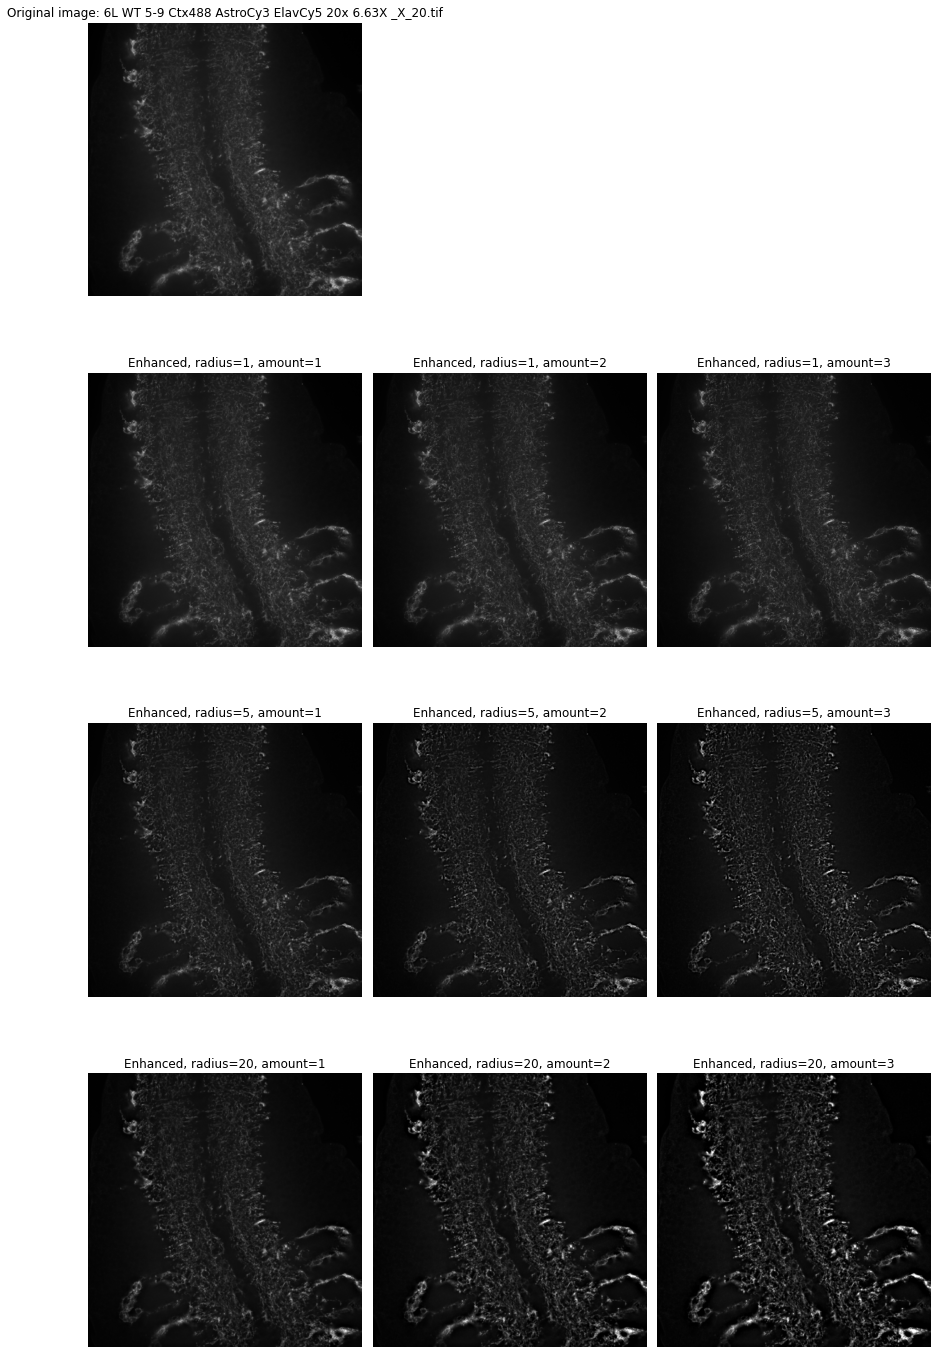

In [4]:
### RUN UNSHARP MASK WITH VARIOUS PARAMATER SETS ON ALL TEST IMAGE SET ###

#test data directory
dataDir = 'TestImages'
#results directory
resultsDir = 'UnsharpMaskResults'
#channel to be denoised
channel = 0
#list of 3 values for radius parameter
radii = [1, 5, 20]
#list of 3 values for amount parameter
amts = [1, 2, 3]

#run unsharp mask on test images
test_unsharp_mask(dataDir, resultsDir, channel, radii, amts)

# Step 2: Thresholding

Thresholding produces the binary images necessary for image quantification. As with denoising, we optimized thresholding separately for each channel. We were unable to find a single thresholding algorithm that produced optimal binary images for all test images. We implemented a decision tree to choose the most appropriate method for each image. 

The code below choses a random image from the test set and binarizes each channel with the appropriate binarizing function. The binarize_neurons, binarize_cortex_glia, binarize_astro functions are the optimized functions used for the final analysis in our accompanying paper. 

In [5]:
def binarize_neurons(fullimg, channel=2):
    '''Binarizes (denoises and thresholds) neuron channel.
    Chooses between the otsu, triangle and li thresholding algorithms using a decision tree. 

    -----PARAMETERS-----
    fullimg: 3D array representing 2D image (row, col, channel)
    channel: integer indicating neuron channel
    
     ----RETURNS----
    (neuronBIN, neuthresh)
    neuronBIN: Binary version of the neuron channel image. 
    neuthresh: Algorithm selected for thresholding channel for troubleshooting purposes
    '''

    #select neuron channel
    neurons=fullimg[:, :, channel]
    #denoise image using unsharp mask 
    #radius = 20, amount = 4 worked best for us
    #can be optimized using Step 1
    unsharp_img = unsharp_mask(neurons, radius=20, amount=4)

    #apply three thresholds options
    #otsu (I refer to image thresholded by otsu algorithm as otsu image)
    #find threshold
    thresh = threshold_otsu(unsharp_img)
    #apply threshold to denoised image to produce binary image
    otsu = unsharp_img > thresh
    #triangle (I refer to image thresholded by triangle algorithm as triangle image)
    thresh=threshold_triangle(unsharp_img)
    triangle = unsharp_img > thresh
    #li (I refer to image thresholded by li algorithm as li image)
    thresh=threshold_li(unsharp_img)
    li = unsharp_img > thresh
    
    #otsu algorithm works for most neuron images so is the default
    #test for cases where it is not optimal
    ##remove specks (objects < some_area) from binary image
    ##most of these specks are noise
    desp_thresh = 75
    otsu_desp = remove_small_objects(otsu, desp_thresh)
    #check if otsu is blown out (overestimating true signal)
    #grab middle subsection (this is where most of the noise is)
    otsu_sub=otsu[:200, 400:800]
    otsu_d_sub=otsu_desp[:200:, 400:800]
    #if despeckling helps "a lot", Otsu is the wrong filter
    ##calculate the percent of pixels removed by despeckling
    desp_fix=otsu_sub.astype(float)-otsu_d_sub.astype(float)
    desp_fix=np.sum(desp_fix)
    desp_fix=desp_fix/(np.shape(otsu_sub)[0]*np.shape(otsu_sub)[1])
    #make sure otsu is not blacked out (underestimating true signal)
    ##there should be neurons in every image (bc of fly CNS morphology)
    ##calculate the number of true pixels after applying otsu
    blackout=np.sum(otsu.astype(float))
    blackout=blackout/(1200*1200)
                
    #choose thresholding algorithm
    #set cutoffs to decide when to use alternatives to Otsu
    ##the ones below worked for us but can be adjusted as necessary
    #if otsu blows out thresholded image, choose triangle
    if desp_fix > 0.07:
        neuronBIN = triangle
        #note which thresholder was used
        neuthresh='triangle'
    #if otsu blacks out thresholded image, choose li
    elif blackout<0.02:
        neuronBIN=li
        neuthresh='li'
    #if otsu image is not blown/backed out, choose otsu
    else:
        neuronBIN=otsu_desp
        neuthresh='otsu desp' 

    return((neuronBIN, neuthresh))

In [6]:
def binarize_cortex_glia (fullimg, channel=1):
    '''Binarizes (denoises and thresholds) cortex glia channel.
    Chooses between the otsu and triangle thresholding algorithms using a decision tree. 

    -----PARAMETERS-----
    fullimg: 3D array representing 2D image (row, col, channel)
    channel: integer indicating cortex glia channel
    
    ----RETURNS----
    (cgBIN, cgthresh)
    cgBIN: Binary version of the cortex glia channel image. 
    cgthresh: Algorithm selected for thresholding channel for troubleshooting purposess
    '''

    #select cortex glia channel
    cortex_glia = fullimg[:, :, channel]
    #denoise image using unsharp mask 
    #radius = 20, amount = 2 worked best for us
    #can be optimized using Step 1
    unsharp_img = unsharp_mask(cortex_glia, radius=20, amount=2)

    #apply two threshold options
    #triangle (I refer to image thresholded by triangle algorithm as triangle image)
    #find threshold
    thresh = threshold_triangle(unsharp_img)
    #apply threshold to denoised image to produce binary image
    triangle = unsharp_img > thresh
    #otsu (I refer to image thresholded by otsu algorithm as otsu image)
    thresh = threshold_otsu(unsharp_img)
    otsu = unsharp_img > thresh
    
    #calculate metrics to decide between triangle and otsu
    #to decide if triangle is blown out (overestimating true signal)
    #grab subsection of triangle image
    tri_sub=triangle[900:1200, 400:800]
    #calculate number of true pixels in the subsection
    tri_overblown=np.sum(tri_sub.astype(float))
    tri_overblown=tri_overblown/(np.shape(tri_sub)[0]*np.shape(tri_sub)[1])
    
    #to decide if otsu is blown out (overestimating true signal)
    #grab subsection of original otsu
    o_sub=otsu[:, 400:800]
    #calculate number of true pixels in subsection
    o_overblown=np.sum(o_sub.astype(float))/(np.shape(o_sub)[0]*np.shape(o_sub)[1])
    ##remove specks (objects < some_area) from binary image
    ##most of these specks are noise
    otsu_desp = remove_small_objects(otsu, 75)
    #grab subsection of despeckled image (where most of the noise is)
    od_sub=otsu_desp[:, 400:800]
    #if despeckling helps "a lot", Otsu is the wrong filter
    #calculate the percent of pixels removed by despeckling in subsection 
    o_overblown2=np.sum(o_sub.astype(float)-od_sub.astype(float))
    o_overblown2=o_overblown2/(np.shape(o_sub)[0]*np.shape(o_sub)[1])

    #choose a thresholding algorithm
    #if neither algorithm is clearly overblown (areas < cutoffs)
    if (o_overblown<0.5 and o_overblown2 < 0.05 and tri_overblown<0.5):
        #choose the one that yields the greatest number of true pixels in subsections
        if o_overblown>tri_overblown:
            cgBIN=otsu
            cgthresh='otsu'
        else:
            cgBIN=triangle
            cgthresh='triangle'
    #if triangle above certain threshold
    else:
        #pick otsu if not overblown
        if (o_overblown<0.5 and o_overblown2< 0.05):
            cgBIN=otsu
            cgthresh='otsu'
        #pick triangle if otsu is overblown
        else:
            cgBIN=triangle
            cgthresh='triangle'            
    return ((cgBIN, cgthresh))

In [7]:
def binarize_astro (fullimg, channel=0):
    '''Binarizes (denoises and thresholds) astrocyte channel.
    Chooses between the otsu, triangle and yen thresholding algorithms using a decision tree. 

    -----PARAMETERS-----
    fullimg: 3D array representing 2D image (row, col, channel)
    channel: integer indicating astrocyte channel
    
    -----RETURNS----
    (astroBIN, astrothresh)
    astroBIN: Binary version of the astrocyte channel image. 
    astrothresh: Algorithm selected for thresholding channel for troubleshooting purposes
    '''

    #select astrocyte channel
    astro=fullimg[:, :, channel]
    #denoise image using unsharp mask 
    #radius = 20, amount = 2 worked best for us
    #can be optimized using Step 1
    unsharp_img = unsharp_mask(astro, radius=20, amount=2)

    #apply three thresholds options
    #triangle (I refer to image thresholded by triangle algorithm as triangle image)
    #find threshold
    thresh = threshold_triangle(unsharp_img)
    #apply threshold to denoised image to produce binary image
    triangle = unsharp_img > thresh
    #otsu (I refer to image thresholded by otsu algorithm as otsu image)
    thresh = threshold_otsu(unsharp_img)
    otsu = unsharp_img > thresh
    #yen (I refer to image thresholded by yen algorithm as yen image)
    thresh=threshold_yen(unsharp_img)
    yen = unsharp_img > thresh
    
    #calculate metrics to decide between algorithms
    #to decide if triangle is blown out (overestimating true signal)
    #grab subsection of triangle image
    tri_sub=triangle[900:1200, :]
    #calculate number of true pixels in the subsection
    tri_overblown=np.sum(tri_sub.astype(float))
    tri_overblown=tri_overblown/(np.shape(tri_sub)[0]*np.shape(tri_sub)[1])

    #check if otsu is blown out (overestimating true signal)
    #grab subsection that tends to get blown out
    o_sub=otsu[800:1200, :]    
    o_overblown=np.sum(o_sub.astype(float))
    o_overblown=o_overblown/(np.shape(o_sub)[0]*np.shape(o_sub)[1])
                
    #choose thresholding algorithm
    #if otsu is not overblown choose otsu
    if o_overblown<0.3:
            astroBIN=otsu
            astrothresh='otsu'
    #if otsu is overblown
    else:
        #choose triangle if not overblown
        if tri_overblown<0.4:
            astroBIN=triangle
            astrothresh='triangle'
        #choose yen if triangle is overblown
        else:
            astroBIN=yen
            astrothresh='yen'
    
    return((astroBIN, astrothresh))

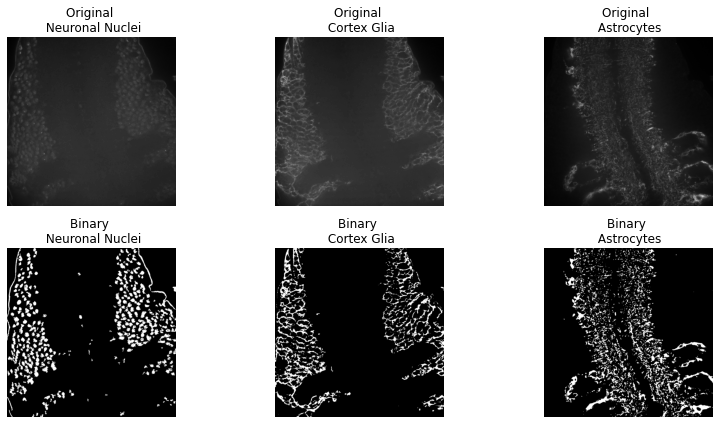

In [8]:
#THRESHOLD RANDOM TEST IMAGE

#make list of test image file names
dataDir = "TestImages"

testImgs = []
for root, dir, file in os.walk(dataDir):
    for f in file:
        if '.tif' in f:
            testImgs.append(f)

#choose random image file
imgName = random.choice(testImgs)
ipath = os.path.join(dataDir, imgName)
#load image with skimage
fullimg = skimage.io.imread(ipath, plugin="tifffile")
#binarize neuron channel
neuronBin, neuronThresh = binarize_neurons(fullimg)
#binarize cortex glia channel 
cgBin, cgThresh = binarize_cortex_glia(fullimg)
#binarize astrocyte channel
astroBin, astroThresh = binarize_astro(fullimg)

#make figure showing original and corresponding binary images
#create figure
fig, axes = plt.subplots(nrows=2, ncols=3,
                         sharex=True, sharey=True, figsize=(12, 6), tight_layout=True)
ax = axes.ravel()
#add original cortex glia, neuron, astrocyte channels
ax[0].imshow(fullimg[:, :, 2], cmap=plt.cm.gray)
ax[0].set_title('Original \n Neuronal Nuclei')

ax[1].imshow(fullimg[:, :, 1], cmap=plt.cm.gray)
ax[1].set_title('Original \n Cortex Glia')

ax[2].imshow(fullimg[:, :, 0], cmap=plt.cm.gray)
ax[2].set_title('Original \n Astrocytes')

#add binary cortex glia, neuron, astrocyte channels
ax[3].imshow(neuronBin, cmap=plt.cm.gray)
ax[3].set_title('Binary \n Neuronal Nuclei')

ax[4].imshow(cgBin, cmap=plt.cm.gray)
ax[4].set_title('Binary \n Cortex Glia')

ax[5].imshow(astroBin, cmap=plt.cm.gray)
ax[5].set_title('Binary \n Astrocytes')

for a in ax:
    a.axis('off')

plt.show()

## Troubleshooting: Thresholding 

### Algorithm selection

For generating our thresholding decision tree, we first used the [try_all_threshold function](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html) to binarize a set of denoised test images and chose 2-3 algorithms (for each channel) that would result in at least one satisfactory binarization of each test image. Scikit-image provides other thresholding algorithms users may wish to use instead, including local thresholding algorithms, in the [filters](https://scikit-image.org/docs/stable/api/skimage.filters.html) modules. 

The try_all_threshold_on_set function below runs the try_all_threshold function to binarize a set of denoised test images and stores the results in a directory denoted by the user. This function was also used in the Neuron_Binarizer_Optimization.py, Astrocyte_Binarizer_Optimization.py, and CortexGlia_Binarizer_Optimization.py scripts in this repo to optimizate the corresponding channel's binarization process. The try_all_threshold_on_set function in this notebook was modified slightly from that in the optimizations scripts to return the figure for the last image for demonstration purposes. 

In [9]:
def try_all_threshold_on_set(dataDir, resultsDir, channel):
    '''runs scikit-image's try_all threshold function on all test images

    -----PARAMETERS-----
    dataDir: filepath to directory containing test data
        3D arrays representing 2D images in the form (pixel_row, pixel_column, channel)
    resultsDir: filepath to directory for storing results. 
    channel: integer indicating channel to be tested
    
    ----RETURNS----
    For each test image, produces a figure showing denoised grayscale image
    and results from global thresholding algorithms. 
    Figures are stored in resultsDir directory.
    '''

    #create results directory
    if not os.path.exists(resultsDir):
        os.makedirs(resultsDir)
    #for each image
    for root, directory, file in os.walk(dataDir):
        for f in file:
            if '.tif' in f:
                ipath=os.path.join(root, f)
                #load image with skimage
                fullimg=skimage.io.imread(ipath, plugin="tifffile")
                #isolate channel
                original=fullimg[:, :, channel]                
                #denoise image
                unsharp_img = unsharp_mask(original, radius=20, amount=2)
                #try global thresholds
                fig, ax = try_all_threshold(unsharp_img, figsize=(4, 6), verbose=False)
                #save results
                imgID = f.replace('.tif', '')
                figpath=os.path.join(resultsDir, imgID + '_THRESHOLD' + '.png')
                plt.savefig(figpath, format='png', pad_inches=0.3, bbox_inches='tight')
                plt.close()
    return (fig)

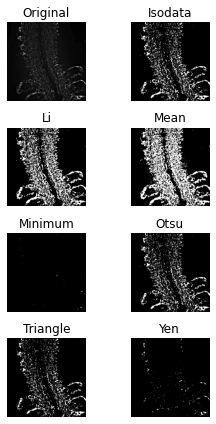

In [10]:
#RUN TRY_ALL_THRESHOLD_ON_SET ON 1 CHANNEL OF ALL TEST IMAGES

#test data directory
dataDir = 'TestImages'
#results directory
resultsDir = 'Threshold_Test_Results'
channel = 0

#run global thresholds on test images
try_all_threshold_on_set(dataDir, resultsDir, channel)


### Decision Tree

The neuron_binarizer_optimization function below was used to optimize the decision tree for thresholding the neuronal nuclei channel. It runs the Otsu, triangle and Li methods on each of the test images and produces a figure showing the results of each algorithm, as well as which it would select to threshold the given image. We took advantage of the difference in texture between the neuronal nuclei (circles) and noise (small specks), and the fact that there are neurons in every slice of the stack, in order to code rules to determine when a thresholding method is over or underestimating the amount of true signal. The neuron_binarizer_optimization function can be modified slightly to choose between different thresholding algorithms or to use different rules for choosing the optimal threshold. You can also find this function in the Neuron_Binarizer_Optimization.py. 

In the code below we modified the neuron_binarizer_optimization function slightly to return the figure for the last image for demonstation purposes. 

You can find similar scripts for optimizing the cortex glia and astrocyte channel binarization process in the Astrocyte_Binarizer_Optimization.py and CortexGlia_Binarizer_Optimization.py files in this repo. 


In [13]:
def neuron_binarizer_optimization (dataDir, resultsDir, channel):
    '''For troubleshooting neuron channel binarization. 
    Selects optimal thresholdingn algorithm from otsu, li, triangle methods

    ----PARAMETERS----
    filepath to directory containing test data
        3D arrays representing 2D images in the form (pixel_row, pixel_column, channel)
    resultsDir: filepath to directory for storing results. 
    channel: integer indicating neuron channel

    ----RETURNS----
    For each test image, produces a figure showing the results of each thresholding algorithm
    and indicating which algorithm would be selected as optimal.
    Notes the values for the two metrics used for selecting optimal algorithm:
        percent of pixels removed from otsu image by despeckling
        percent true pixels in otsu image
    Figures are stored in resultsDir directory.
    '''
    
    #create results directory
    if not os.path.exists(resultsDir):
        os.makedirs(resultsDir)
    for root, directory, file in os.walk(dataDir):
        for f in file[:]:
            if '.tif' in f:
                ipath=os.path.join(root, f)
                #load image with skimage
                fullimg=skimage.io.imread(ipath, plugin="tifffile")
                #select single channel
                original=fullimg[:, :, channel]
                
                #denoise image using unsharp mask 
                #radius = 20, amount = 4 worked best for us
                #can be optimized using Step 1
                unsharp_img = unsharp_mask(original, radius=20, amount=4)

                #apply three thresholds being tested to test image
                #otsu 
                ##I refer to image thresholded by otsu algorithm as otsu image
                #find threshold
                thresh = threshold_otsu(unsharp_img)
                #apply threshold to denoised image to produce binary image
                otsu = unsharp_img > thresh
                #triangle
                ##I refer to image thresholded by triangle algorithm as triangle image
                thresh=threshold_triangle(unsharp_img)
                triangle = unsharp_img > thresh
                #li
                ##I refer to image thresholded by li algorithm as li image
                thresh=threshold_li(unsharp_img)
                li = unsharp_img > thresh
                
                #otsu algorithm works for most neuron images so is the default
                #test for cases where it is not optimal
                ##remove specks (objects < some_area) from binary image
                ##most of these specks are noise
                otsu_desp = remove_small_objects(otsu, 75)
                #check if otsu is blown out (overestimating true signal)
                #grab middle subsection (this is where most of the noise is)
                otsu_sub=otsu[:200, 400:800]
                otsu_d_sub=otsu_desp[:200:, 400:800]
                #if despeckling helps "a lot", Otsu is the wrong filter
                ##calculate the percent of pixels removed by despeckling
                desp_fix=otsu_sub.astype(float)-otsu_d_sub.astype(float)
                desp_fix=np.sum(desp_fix)
                desp_fix=desp_fix/(np.shape(otsu_sub)[0]*np.shape(otsu_sub)[1])
                #make sure otsu is not blacked out (underestimating true signal)
                ##there should be neurons in every image (bc of fly CNS morphology)
                ##calculate the number of true pixels after applying otsu
                blackout=np.sum(otsu.astype(float))
                blackout=blackout/(1200*1200)
                
                #choose thresholding algorithm
                #set cutoffs to decide when to use alternatives to Otsu
                ##the ones below worked for us but can be adjust as necessary
                #if otsu blows out thresholded image, choose triangle
                if desp_fix > 0.07:
                    good = triangle
                    gthresh='triangle'
                    bad1 = otsu_desp
                    bthresh1='Otsu, despeckled'
                    bad2 = li
                    bthresh2 = 'Li'
                #if otsu blacks out thresholded image, choose li
                elif blackout<0.02:
                    good=li
                    gthresh='Li'
                    bad1=otsu_desp
                    bthresh1='Otsu, despeckled'
                    bad2=triangle
                    bthresh2='Triangle'
                #if otsu image is not blown/backed out, choose otsu
                else:
                    good=otsu_desp
                    gthresh='Otsu, despeckled'
                    bad1=triangle
                    bthresh1='triangle'
                    bad2=li
                    bthresh2='Li'
                
                #create figure showing result of otsu, li, triangle
                #and labeling the optimal algorithm
                #create figure
                fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
                ax = axes.ravel()
                plt.gray()
                #original image
                ax[0].imshow(original)
                ax[0].set_title(f + '\n Original')
                #denoised image
                ax[1].imshow(unsharp_img)
                ax[1].set_title('Denoised')
                #original otsu image without despeckling
                ax[2].imshow(otsu)
                ax[2].set_title('Otsu original')
                #image thresholded by optimal algorithm
                ax[3].imshow(good)
                #note the percent of pixels removed from otsu image by despeckling
                #note the number of true pixels in otsu image
                ax[3].set_title('Picked: ' + gthresh + '   (' +str(round(desp_fix*100, 3)) 
                                + ', ' + str(round(blackout*100, 3)) + ')' ) 
                #image thresholded by suboptimal algorithm #1 
                ax[4].imshow(bad1)
                ax[4].set_title(bthresh1)
                #image thresholded by suboptimal algorithm #2
                ax[5].imshow(bad2)
                ax[5].set_title(bthresh2)
                #take axis off
                for a in ax:
                    a.axis('off')
                #save image in results folder
                imgID = f.replace('.tif', '')
                figpath=os.path.join(resultsDir, imgID + 'NeuTHRESH' + '.png')
                plt.savefig(figpath, format='png', pad_inches=0.3, bbox_inches='tight')
                #suppress output showing every figure
                plt.close()
    return(fig)

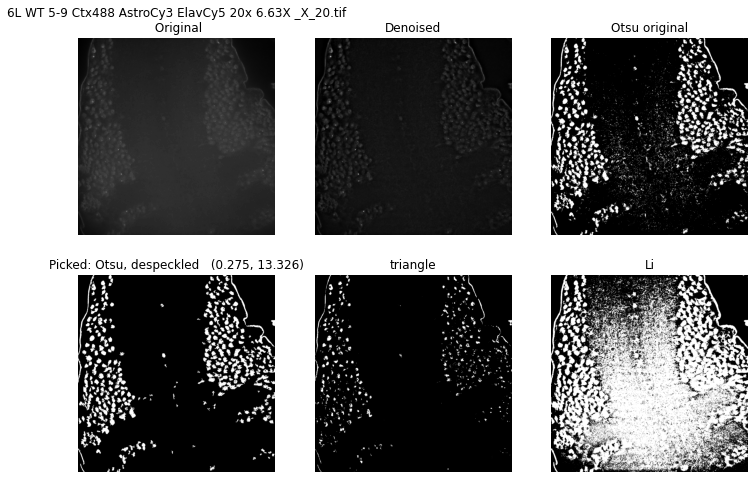

In [12]:
# RUN NEURON_BINARIZER_OPTIMIZATION ON ALL IMAGES IN TEST SET

dataDir='TestImages'
resultsDir = 'NeuronBinarizerRes'
channel = 2

neuron_binarizer_optimization (dataDir, resultsDir, channel)

# Step 3: Quantification 

## Globularity Quantification: AMI
The perimeter is used as a proxy for automatically quantifying globularity. A highly significant negative relationship was established between cortex glia perimeter and globularity by comparing the length of the perimeter, normalized by cortex area, to globularity scores manually assigned by researchers. You can fnd the code for assessing this relationship in the AMI_Validation.py in this repo and a full explanation of the validation process in our accompanying paper. 

## Aberrant Infiltration Quantification: AIS
Aberrant infiltration is measured as the overlap between the cortex region and the astrocyte channel. Automated infiltration quantification was validated by comparing manual and automated scores. You can find the code for this validation in AIS_Validation.py in this repo and a full explanation of the validation process in our accompanying paper. 

The functions below perform globularity and aberrant infiltration simultaneously on 3-channel 2D images, and were used to produce preliminary AMI and AIS scores for validating the pipeline, as well as for quantifying the full z-stacks for the final analysis. The code for perfoming the full quantification can be found in Z_Stack_Quantification.py in this repo. 

In [16]:
def connect_the_dots (cortex_prelim, n, threshold):
    '''Connects objects that are close in the cortex segmentation 
    to produce a solid region representing cortex.
    Turns any black pixels from False (0) to True (1)
    based on the proportion of its neighbors that are True

    ----PARAMETERS---
    cortex_prelim: boolean array representing preliminary cortex segmentation 
    n: neighborhood radius
    threshold: cutoff above which to turn pixels to True (0)

    ----RETURNS----   
    boolean array representing cortex segmentation
    '''

    #make copy of preliminary cortex
    filled_ctx=np.copy(cortex_prelim)
    
    #iterate through pixels
    for i in range(np.shape(cortex_prelim)[0]):
        for j in range(np.shape(cortex_prelim)[1]):
            #find corners of neighborhood
            if i>=n: 
                istart=i-n
            else:
                istart=0  
            if j>=n:
                jstart=j-n
            else:
                jstart=0
            
            if i+n<=np.shape(cortex_prelim)[0]-1:
                iend=i+n
            else:
                iend=np.shape(cortex_prelim)[0]-1
            if j+n<=np.shape(cortex_prelim)[1]-1:
                jend=j+n
            else:
                jend=np.shape(cortex_prelim)[1]-1
            
            #isolate neighborhood
            neighborhood=cortex_prelim[istart:iend, jstart:jend]
            #calculate size of neighborhood
            n_size=np.shape(neighborhood)[0]*np.shape(neighborhood)[1]
            #if neighborhood area is >0
            if n_size>0:
                #turn pixel from 0 to 1 if above set cutoff
                if np.sum(neighborhood)/n_size>threshold:
                    filled_ctx[i, j]=1
                else:
                    filled_ctx[i,j]=cortex_prelim[i,j]
    #convert to boolean
    filled_ctx=filled_ctx.astype(bool)

    return(filled_ctx)

In [17]:
def segment_cortex (cgBIN, neuronBIN, ndil=3, n=15, threshold=0.1, 
                    ctxholes=5000, ctxer=10):
    '''Segments cortex by combining neuron and cortex glia channels
    Fills holes in preliminary segmentation in 2 steps (1st fill, 2nd fill)
        to produce solid region 
    Adjusts segmentation with an erosion. 

    ---PARAMETERS----
    cgBIN: 2D boolean array representing binary cortex glia image
    neuronBIN: 2D boolean array representing binary cortex glia image
    ndil: number of times to dilate binary neuron image
    n: neighborhood radius for first fill 
    threshold: cutoff for turning pixels from False to True in 1st fill 
    ctxholes: area of holes to fill in 2nd fill 
    ctxer: number of erosions for final adjustment

    ---RETURNS----
    AMI: Automated morphology index, metric for globularity 
    '''

    #dilate neuron channel
    for i in range(ndil):
        neuronBINdil=binary_dilation(neuronBIN)
    
    #add cortex glia & neuron channels 
    ctxBIN=neuronBINdil+cgBIN

    #1st fill 
    ctxBINfilled = connect_the_dots(ctxBIN, n, threshold)
    #2nd fill
    ctxBINfinal = remove_small_holes(ctxBINfilled, ctxholes)
    
    #final erosion
    for i in range(ctxer):
        ctxBINfinal=binary_erosion(ctxBINfinal)
            
    return(ctxBINfinal)

In [18]:
def calc_AMI(cgBIN, ctxArea):
    '''Quantifies globularity.

    ---PARAMETERS----
    cgBIN: 2D boolean array representing cortex glia channel
    ctxArea: area of cortex region 

    ---RETURNS----
    AMI: Automated morphology index, metric for globularity 
    '''

    #measure perimeter
    ctxPer = perimeter(cgBIN, neighbourhood=4)
    #normalize, express as percent
    AMI = ctxPer/ctxArea*100

    return(AMI)

In [19]:
def calc_AIS(cortexBIN, astroBIN, ctxArea, 
             cbod_area1=500, cbod_area2=1500, cbod_area3=4000, cbod_area4=5000,
             solid1=0.6, solid2=0.4, ecc1=0.85, 
             return_troubleshooting_img = False, resultsDir=None, sliceID=None):
    
    '''Quantifies aberrant infiltration.

    ---PARAMETERS----
    cortexBIN: 2D boolean array representing cortex region
    astroBIN: 2D boolean array representing astroctyte channel 
    ctxArea: area of cortex region
    return_troubleshooting_img: boolean
        True will produce an image showing all objects in preliminary infiltration
        objects excluded from final infiltration are bounded by a red box
    resultsDir: filepath indicating where to create directory named 'TS_figs'
        for saving troubleshooting figures

    ---RETURNS----
    AIS: Automated infiltration score, metric for aberrant infiltration 
    '''

    #find overlap between cortex and astrocytes 
    ctx_inf=img_as_float(cortexBIN)
    ncg_inf=img_as_float(astroBIN)
    
    inf=ctx_inf+ncg_inf
    inf=inf-1
    inf=np.clip(inf, 0, 1)
    prelim_inf=inf.astype(int)

    # prelim_inf = cortexBIN==astroBIN
    #turn to floats
    prelim_inf = prelim_inf.astype(float)
    
    #CELL BODY EXCLUSION
    #label all objects
    label_inf=label(prelim_inf)
    #measure properties for each object
    rprops= regionprops(label_inf)
    #create final infiltration array to edit
    finalinf=np.copy(prelim_inf)

    #don't produce troubleshooting image
    if return_troubleshooting_img == False:
        #use object areas, eccentricity, and solidity to exclude cell bodies from 
        #final infiltration count
        for region in rprops:
            if region.area > cbod_area1 and region.area <= cbod_area2:
                if region.eccentricity < ecc1:
                    #remove objects fitting the above conditions
                    #from final infiltration 
                    for c in region.coords:
                        finalinf[c[0], c[1]]=0
            if region.area > cbod_area2 and region.area<=cbod_area3:
                if region.solidity>solid1:
                    for c in region.coords:
                        finalinf[c[0], c[1]]=0
                elif region.solidity>solid2 and region.eccentricity<ecc1:
                    for c in region.coords:
                        finalinf[c[0], c[1]]=0
                #to exclude
            if region.area > cbod_area4:
                minr, minc, maxr, maxc = region.bbox
                for c in region.coords:
                    finalinf[c[0], c[1]]=0

    #produce troubleshooting image
    else:
        #create directory to save all troubleshooting images
        TS_Dir = os.path.join(resultsDir, 'TS_figs')
        if not os.path.exists(TS_Dir):
            os.makedirs(TS_Dir)
        #create image
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        plt.gray()
        #show preliminary infiltration 
        ax.imshow(prelim_inf)
        #chose color for bounding excluded objects
        excludeColor='red'
        #use object areas, eccentricity, and solidity to exclude cell bodies from 
        #final infiltration count
        for region in rprops:
            if region.area > cbod_area1 and region.area <= cbod_area2:
                #to exclude
                if region.eccentricity < ecc1:
                    #create bounding box around excluded objects
                    minr, minc, maxr, maxc = region.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor=excludeColor, linewidth=1)   
                    ax.add_patch(rect)
                    #remove objects fitting the above conditions
                    for c in region.coords:
                        finalinf[c[0], c[1]]=0
            if region.area > cbod_area2 and region.area<=cbod_area3:
                #to exclude 
                if region.solidity>solid1:
                    minr, minc, maxr, maxc = region.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor=excludeColor, linewidth=1) 
                    ax.add_patch(rect)
                    for c in region.coords:
                        finalinf[c[0], c[1]]=0
                elif region.solidity>solid2 and region.eccentricity<ecc1:
                    minr, minc, maxr, maxc = region.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor=excludeColor, linewidth=1) 
                    ax.add_patch(rect)
                    for c in region.coords:
                        finalinf[c[0], c[1]]=0
            #to exclude
            if region.area > cbod_area4:
                minr, minc, maxr, maxc = region.bbox
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor=excludeColor, linewidth=1)   
                ax.add_patch(rect)
                for c in region.coords:
                    finalinf[c[0], c[1]]=0    
        ax.set_title(sliceID)
        ax.axis('off')
        #save image in results folder
        imgID = sliceID.replace('.tif', '')
        figpath=os.path.join(TS_Dir, imgID + 'TS' + '.png')
        plt.savefig(figpath, format='png', pad_inches=0.3, bbox_inches='tight')
        #suppress output showing every figure
        plt.close()

    #calculate final infiltration area
    infArea = np.sum(finalinf.astype(float))
    #normalize to cortex area
    AIS = infArea/ctxArea*100
    return (AIS)


In [20]:
def quantify_slice(fullimg, sliceID,
                   neuron_channel=0, cortexglia_channel=1, astrocyte_channel=2,
                   return_troubleshooting_img = False, resultsDir=None):
    '''Quantifies globularity and aberrant infiltration for a 2D three-channel slice.

    -----PARAMETERS----
    fullimg: 3D array representing 2D images in the form (pixel_row, pixel_column, channel)
    sliceID: unique filename of image serves as sliceID
    neuron_channel: integer indicating neuron channel 
    cortexglia_channel: integer indicating cortex glia channel 
    astrocyte_channel: integer indicating astrocyte channel 
    return_troubleshooting_img: boolean
        True will save an image showing all objects in preliminary infiltration
        objects excluded from final infiltration are bounded by a red box

    ----RETURNS----
    (GT, sliceID, AMI, AIS)
    GT: genotype indicates experimental group
        6L: non-RNAi control
        7L: driver 1 knockdown 
        8L: driver 2 knockdown
    AMI: Automated morphology index, metric for globularity 
    AIS: Automated infiltration score, metric for aberrant infiltration 
    '''
    #GT code (6L, 7L, 8L) is included in all image filenames/sliceID
    #find which code is in sliceID to determine GT 
    GTs=['6L', '7L', '8L']
    for gt in GTs:
        if gt in sliceID:
            GT = gt
    
    #binarize neuron channel, turn from boolean to floats
    neuronBIN, neuronTHRESH = binarize_neurons(fullimg, neuron_channel)
    #binarize cortex glia channel, turn from boolean to floats
    cgBIN, CGTHRESH = binarize_cortex_glia(fullimg, cortexglia_channel)
    #binarize astrocyte channel, turn from boolean to floats
    astroBIN, astroThresh = binarize_astro(fullimg, astrocyte_channel)

    #segment cortex
    cortexBIN = segment_cortex(cgBIN, neuronBIN)
    #calculate cortex area for normalization 
    ctxArea = np.sum(cortexBIN.astype(float))

    #calculate AMI
    AMI = calc_AMI(cgBIN, ctxArea)
    
    #calculate AIS
    #no troubleshooting image
    if return_troubleshooting_img == False:
        AIS = calc_AIS(cgBIN, astroBIN, ctxArea)
    #for saving troubleshoothing image
    else:
        AIS = calc_AIS(cgBIN, astroBIN, ctxArea, 
                       return_troubleshooting_img=True, resultsDir=resultsDir,
                       sliceID=sliceID)
    return ((GT, sliceID, AMI, AIS))


In [23]:
#QUANTIFY ALL TEST IMAGES AND MAKE CSV WITH RESULTS

dataDir='TestImages'

#create results directory
resultsDir = 'TestRun'
if not os.path.exists(resultsDir):
    os.makedirs(resultsDir)

#create csv to write data as it is gathered
newRunPathcsv=os.path.join(resultsDir, newRun+'.csv')
with open(newRunPathcsv, "w", newline='') as rec:
    writer = csv.writer(rec, delimiter=',')
    writer.writerow(["GT", "sliceID", "AMI", "AIS"])
    rec.close()

#iterate through test images
#create list to hold files that caused errors
errors = []
for root, directory, file in os.walk(dataDir):
    for f in file:
        if '.tif' in f:
            try:
                ipath=os.path.join(root, f)
                #define sliceID
                sliceID = f
                #load image
                fullimg=skimage.io.imread(ipath, plugin="tifffile")
                #quantify image
                measurements = quantify_slice(fullimg, sliceID)
                #write data on csv
                with open(newRunPathcsv, 'a', newline='') as rec:
                    writer = csv.writer(rec, delimiter=',')
                    writer.writerow(measurements)
                    rec.close()
            except:
                #add errors to list
                errors.append(f)

#check if there are errors
print (errors)

[]


## Plot preliminary results

Plot distributions of test images scores by genotype. 

Note: this is a very preliminary analysis using a small subset of all the images analyzed in our study. It is only for demonstration purposes and may not reproduce the findings discussed in our paper. 

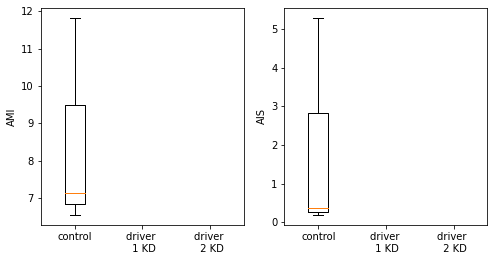

In [26]:
#PLOT TEST RESULTS

#load data 
newRun = 'TestRun'
newRunPathcsv=os.path.join(newRun, newRun+'.csv')
quantification = pd.read_csv(newRunPathcsv, index_col=False)

#AMI split by group
ctrl_AMI = quantification.AMI[quantification.GT =='6L']
KD1_AMI = quantification.AMI[quantification.GT =='7L']
KD2_AMI = quantification.AMI[quantification.GT =='8L']
AMI = [ctrl_AMI, KD1_AMI, KD2_AMI]

#AIS split by group
ctrl_AIS = quantification.AIS[quantification.GT =='6L']
KD1_AIS = quantification.AIS[quantification.GT =='7L']
KD2_AIS = quantification.AIS[quantification.GT =='8L']
AIS = [ctrl_AIS, KD1_AIS, KD2_AIS]

#make violin plot showing distributions
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(8, 4))

#graph AMI
ax1.boxplot(AMI)
ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(['control', 'driver \n 1 KD', 'driver \n 2 KD'])
ax1.set_ylabel('AMI')

#graph AIS
ax2.boxplot(AIS)
ax2.set_xticks([1, 2, 3])
ax2.set_xticklabels(['control', 'driver \n 1 KD', 'driver \n 2 KD'])
ax2.set_ylabel('AIS')

plt.show()


## Troubleshooting: AIS

### Cortex Segmentation Optimization

We determined values for the 4 cortex_segmentation function parameters by comparing automated to manual segmentation. We maximized the overlap between the segmented regions while minimizing the area included in the automatically-segmented region that was not present in the manually-segmented region. You can find the code for this optimization in Cortex_Segmentation_Optimization.py and a full explanation of the optimization process in our accompanying paper. The values of these parameters can be adjusted as necessary to yield scores that more accurately reflect manual scores. 

### Removing Cell Bodies

Astrocyte cell bodies lie on the edge of the cortex region and may be erroneously counted as aberrant infiltration. After performing preliminary infiltration quantification, cell bodies are identified using features such as solidity, area, and eccentricity and excluded from the final score. For the selection of parameter values we labeled all objects in the initial infiltration quantification, manually assigned them a label of “true” or “false” infiltration and chose parameter values that maximized the number of “true” and minimized the number of “false” particles included in the final infiltration count. You can find code for labeling infiltration objects in Cell_Body_Identification.py. 

Scikit-image offers [functions](https://colab.research.google.com/drive/1RnDEMb2QYd2AsKFXV1Qs7q5RwQTUx-TE#scrollTo=EmoMoFlkGrbd&line=11&uniqifier=1) for measuring many features that can be used to identify objects that need to be excluded from an image quantification. 

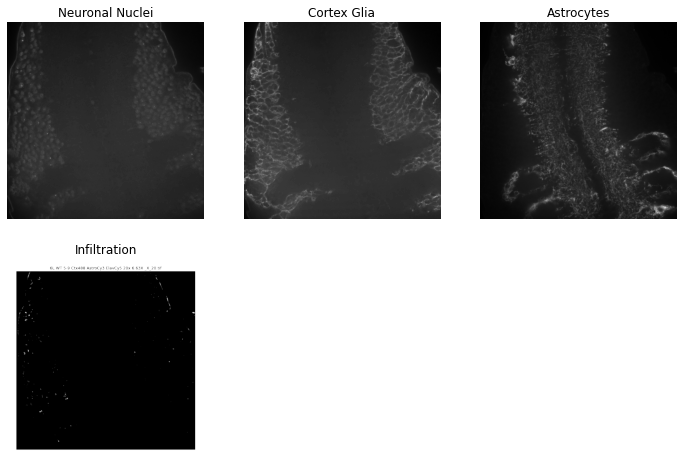

In [28]:
#make list of test image file names
dataDir = "TestImages"

testImgs = []
for root, dir, file in os.walk(dataDir):
    for f in file:
        if '.tif' in f:
            testImgs.append(f)

#choose random image file
imgName = random.choice(testImgs)
ipath = os.path.join(dataDir, imgName)
#load image
fullimg=skimage.io.imread(ipath, plugin="tifffile")

#quantify slice and save troubleshooting figure
quantify_slice(fullimg, imgName, 
               return_troubleshooting_img=True, resultsDir=dataDir)

#load troubleshooting figure 
sliceID=imgName.replace('.tif', '')
TS_fig_path = os.path.join(dataDir, 'TS_figs', sliceID + 'TS' + '.png')
TS_fig=skimage.io.imread(TS_fig_path)

#create figure
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
ax=axes.ravel()
#show neuron channel 
ax[0].imshow(fullimg[:, :, 2])
ax[0].set_title('Neuronal Nuclei')
#show cortex glia channel
ax[1].imshow(fullimg[:, :, 1])
ax[1].set_title('Cortex Glia')
#show astrocyte channel 
ax[2].imshow(fullimg[:, :, 0])
ax[2].set_title('Astrocytes')
#show troubleshooting figure
ax[3].imshow(TS_fig)
ax[3].set_title('Infiltration')

ax[4].remove()
ax[5].remove()

for a in ax:
    a.axis('off')

plt.show()

# Step 4: Analysis 

After quantifycation of all z-stacks, we performed two types of analysis: one considering global scores and the other considering local scores. 

## Global Scores
Global scores are the average of all the slices in a z-stack, representing the VNC of a single animal. We compared global AMI and AIS of the three groups (two RNAi knockdown conditions and one no-RNAi control) using a Kruskal-Wallis test followed by a Dunn pairwise comparisons. We also assessed the relationship between globularity and infiltration using Spearman’s rank correlation coefficient. The full analysis code for global scores can be found in Global_Score_Analysis.py. 

## Local scores
Local scores are the average of a subset of the slices in a z-stack, represent a subregion of the VNC. A sliding window was used to average the scores for 10% of the total slices in a stack at a time, showing how AMI and AIS vary through the dorsal-ventral axis of the VNC. The relationship between corresponding local globularity and infiltration scores was calculated using Spearman’s rank correlation coefficient, showing how the relationship between the two features varies along the dorsal ventral axis. The full analysis code for local scores can be found in Local_Score_Analysis.py. 

